## Google Drive setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Importing libraries 🛬

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import os


#sklearn modules
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix


#tensorflow modules
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

## Loading data to X,y arrays

Resizing all the images to (224,224) format

In [ ]:
X_full=[]
y_full=[]
labels=['category1_tumor','category2_tumor','category3_tumor','no_tumor']

#kaggle_dir='/kaggle/input/rootcode'
main_directory = '/content/drive/MyDrive/Colab Notebooks'

for label in labels:
    #getting the current path
    folder_path = os.path.join(main_directory,'Datathon-Dataset', label)
    for img in os.listdir(folder_path):
        img_path =os.path.join(folder_path,img)
        img_arr  =cv2.imread(img_path)
        img_arr  =cv2.resize(img_arr,(224,224))  #resizing the images for all to have a constant 224 x 224 size
        X_full.append(img_arr)
        y_full.append(label)         #appending the label ,ex:'no tumor'

#conversion to a numpy array
X_full = np.array(X_full)
y_full = np.array(y_full)

## Shuffling & Normalizing

In [ ]:
#shuffling the dataset to give some randomnesss to the data
X_full, y_full = shuffle(X_full ,y_full, random_state=0)
#normalizing
X_full=X_full/255.0

## Visualizing a sample

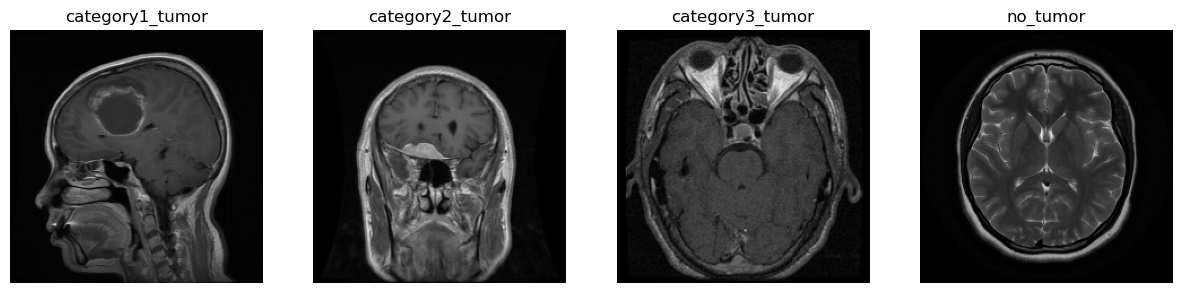

In [ ]:
class_images = {label: [] for label in labels}
for j, label in enumerate(y_full):
    class_images[label].append(X_full[j])

fig, ax = plt.subplots(1, 4, figsize=(15, 15))

# Looping through each class and displays a sample image
for idx, (label, images) in enumerate(class_images.items()):
    sample_image = images[0]
    ax[idx].imshow(sample_image)
    ax[idx].set_title(label)
    ax[idx].axis('off')

plt.show()


##Splitting the data into train & test

In [ ]:
X_train , X_test, y_train , y_test= train_test_split(X_full, y_full, test_size=0.2, random_state=0)

In [ ]:
X_train.min() , X_train.max()  #should be between 0 & 1

(0.0, 1.0)

#Turning y categorical vector to one hot encoded matrix


*   y train categorical -> y_train one-hot
*   y test categorical  -> y_test one-hot




In [ ]:
# one hot encoding the y_train set
y_train_new=[]
for i in y_train:
    y_train_new.append(labels.index(i))

y_train  = y_train_new
y_train  = to_categorical(y_train)

# one hot encoding the y_test set
y_test_new=[]
for i in y_test:
    y_test_new.append(labels.index(i))

y_test  = y_test_new
y_test  = to_categorical(y_test)

##Stating the model ⚒

In [ ]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(filters =80 , kernel_size= (3,3) ,activation='relu', input_shape=(224,224,3) ))
model.add(tf.keras.layers.MaxPooling2D( pool_size=(2,2) ))

model.add(tf.keras.layers.Conv2D(filters=112, kernel_size=(5,5), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(tf.keras.layers.Conv2D(filters=192, kernel_size=(3,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Conv2D(filters=400, kernel_size=(3,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(tf.keras.layers.Conv2D(filters=368, kernel_size=(3,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.BatchNormalization())


#flattening the feature map
model.add(tf.keras.layers.Flatten())

#adding fully connected dense layers
model.add(tf.keras.layers.Dense(176, activation='relu', kernel_regularizer=l2(0.01) ))
model.add(tf.keras.layers.Dense(704, activation='relu', kernel_regularizer=l2(0.01) ))
model.add(tf.keras.layers.Dense(144, activation='relu',kernel_regularizer=l2(0.01)))
model.add(tf.keras.layers.Dense(160, activation='relu',kernel_regularizer=l2(0.01)))

model.add(tf.keras.layers.Dense(4, activation='softmax'))

#compile
model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 80)      2240      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 80)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 107, 107, 112)     224112    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 112)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 51, 51, 192)       193728    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 25, 25, 192)      0

## Using built-in callback functions

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

#using built in callback functions
checkPoint =ModelCheckpoint('best_model.h5',monitor='val_loss',verbose=1, save_best_only=True) #will save the best model for validation loss

reduceLR =ReduceLROnPlateau(monitor='val_loss',patience=3) #if val loss didnt reduce for 3 epochs, will reduce the LR

earlyStopping = EarlyStopping(monitor='val_loss', patience=5) #stop if val loss didnt reduce for 5 epochs

## Fitting the Model ⚡

In [ ]:
history = model.fit( X_train, y_train ,validation_split= 0.1,verbose=1,  epochs=12 , batch_size=16, callbacks=[checkPoint, reduceLR, earlyStopping])

Epoch 1/12
146/146 [==============================] - ETA: 0s - loss: 9.9918 - accuracy: 0.6704
Epoch 1: val_loss improved from inf to 10.34892, saving model to best_model.h5
146/146 [==============================] - 27s 82ms/step - loss: 9.9918 - accuracy: 0.6704 - val_loss: 10.3489 - val_accuracy: 0.2907 - lr: 1.0000e-04
Epoch 2/12
145/146 [============================>.] - ETA: 0s - loss: 8.0828 - accuracy: 0.8241
Epoch 2: val_loss improved from 10.34892 to 9.63632, saving model to best_model.h5
146/146 [==============================] - 10s 67ms/step - loss: 8.0823 - accuracy: 0.8242 - val_loss: 9.6363 - val_accuracy: 0.2636 - lr: 1.0000e-04
Epoch 3/12
145/146 [============================>.] - ETA: 0s - loss: 6.7073 - accuracy: 0.8978
Epoch 3: val_loss improved from 9.63632 to 8.24946, saving model to best_model.h5
146/146 [==============================] - 10s 68ms/step - loss: 6.7084 - accuracy: 0.8975 - val_loss: 8.2495 - val_accuracy: 0.3023 - lr: 1.0000e-04
Epoch 4/12
145/14

##Accuracy chart 📈

/tmp/ipykernel_257/2062077670.py:5: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "ro-" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(epochs, train_acc , 'ro-', label ='Training accuracy',marker='o' )
/tmp/ipykernel_257/2062077670.py:6: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "go-" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(epochs, val_acc ,'go-', label='Validation accuracy', marker='o')


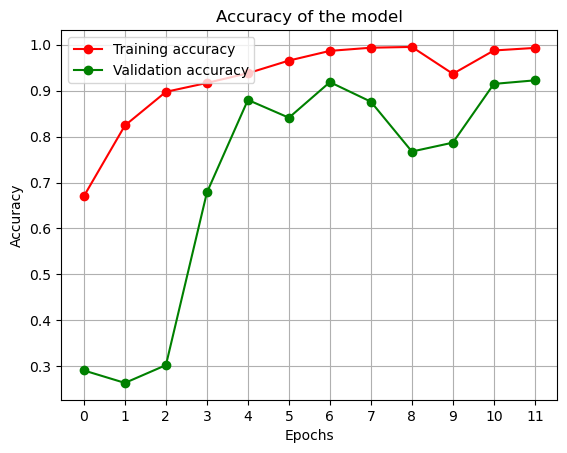

In [ ]:
train_acc =history.history['accuracy']
val_acc =history.history['val_accuracy']
epochs=range(len(train_acc))

plt.plot(epochs, train_acc , 'ro-', label ='Training accuracy',marker='o' )
plt.plot(epochs, val_acc ,'go-', label='Validation accuracy', marker='o')
plt.title('Accuracy of the model')
plt.legend(loc='upper left')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(epochs)  # x-axis ticks to be the same as epochs
plt.grid()
plt.show()



## Loss chart 📉

/tmp/ipykernel_28/1486902785.py:4: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "ro-" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(epochs, train_loss , 'ro-', label ='Training loss' ,marker='o')
/tmp/ipykernel_28/1486902785.py:5: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "go-" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(epochs, val_loss ,'go-', label='Validation loss',marker='o')


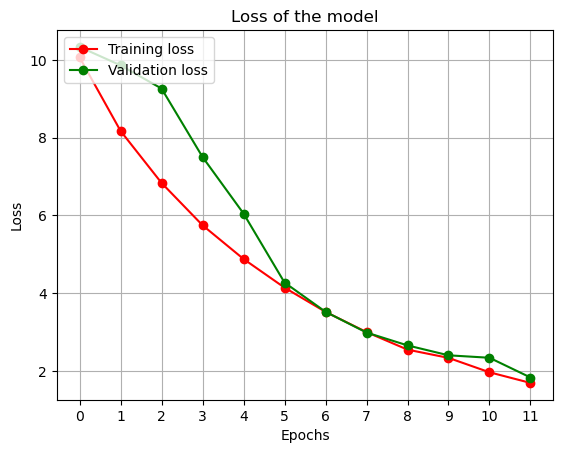

In [ ]:
train_loss=history.history['loss']
val_loss= history.history['val_loss']

plt.plot(epochs, train_loss , 'ro-', label ='Training loss' ,marker='o')
plt.plot(epochs, val_loss ,'go-', label='Validation loss',marker='o')
plt.title('Loss of the model')
plt.legend(loc='upper left')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.grid()
plt.show()


##testing on the test set 🧪

In [ ]:
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob,axis=1)           #converting predicted probabilities in to class labels

y_true_test = np.argmax(y_test,axis=1)   #convert true one-hot encoded labels to true class labels

21/21 [==============================] - 3s 56ms/step


## Confusion matrix 🔲

In [ ]:
conf_matrix = confusion_matrix(y_true_test, y_pred)

In [ ]:
conf_matrix

array([[152,  30,   0,   4],
       [ 11, 172,   1,   1],
       [  0,   8, 159,   0],
       [  0,  11,   0,  96]])

## Generate classification report 📊

Since this is image analysis on MRI scans, accuracy is not the best evaluation metric and also since the classes are imbalanced, we generated a classification report

In [ ]:
print(classification_report(y_true_test,  y_pred))

              precision    recall  f1-score   support

           0       0.93      0.82      0.87       186
           1       0.78      0.93      0.85       185
           2       0.99      0.95      0.97       167
           3       0.95      0.90      0.92       107

    accuracy                           0.90       645
   macro avg       0.91      0.90      0.90       645
weighted avg       0.91      0.90      0.90       645



We were able to obtain a f1-score of [0.87 ,0.85, 0.97, 0.92] and also an accuracy of 0.9 🥳